In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import scipy as sp
from shutil import copyfile

from scipy import ndimage
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [2]:
try:
    os.mkdir('cats-v-dogs')
    os.mkdir('cats-v-dogs/training')
    os.mkdir('cats-v-dogs/validation')
    os.mkdir('cats-v-dogs/test')
    os.mkdir('cats-v-dogs/training/cats')
    os.mkdir('cats-v-dogs/training/dogs')
    os.mkdir('cats-v-dogs/validation/cats')
    os.mkdir('cats-v-dogs/validation/dogs')
    os.mkdir('cats-v-dogs/test/cats')
    os.mkdir('cats-v-dogs/test/dogs')
except OSError:
    print('Error failed to make directory')

Error failed to make directory


In [3]:
#Define data path
CAT_DIR = 'C:/Users/AJAY/Desktop/Major project/cats/cats'
DOG_DIR = 'C:/Users/AJAY/Desktop/Major project/dogs/dogs'

TRAINING_DIR = "C:/Users/AJAY/Desktop/Major project/cats-v-dogs/training/"
VALIDATION_DIR = "C:/Users/AJAY/Desktop/Major project/cats-v-dogs/validation/"

TRAINING_CATS = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS = os.path.join(VALIDATION_DIR, "dogs/")

# Define whether to include test split or not
INCLUDE_TEST = True

In [4]:
def split_data(main_dir, training_dir, validation_dir, test_dir=None, include_test_split = True,  split_size=0.9):
    files = []
    for file in os.listdir(main_dir):
        if  os.path.getsize(os.path.join(main_dir, file)): # check if the file's size isn't 0
            files.append(file) # appends file name to a list

    shuffled_files = random.sample(files,  len(files)) # shuffles the data
    split = int(0.9 * len(shuffled_files)) #the training split casted into int for numeric rounding
    train = shuffled_files[:split] #training split
    split_valid_test = int(split + (len(shuffled_files)-split)/2)
   
    if include_test_split:
        validation = shuffled_files[split:split_valid_test] # validation split
        test = shuffled_files[split_valid_test:]
    else:
        validation = shuffled_files[split:]

    for element in train:
        copyfile(os.path.join(main_dir,  element), os.path.join(training_dir, element)) # copy files into training directory

    for element in validation:
        copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))# copy files into validation directory
        
    if include_test_split:
        for element in test:
            copyfile(os.path.join(main_dir,  element), os.path.join(test_dir, element)) # copy files into test directory
    print("Split sucessful!")

In [5]:
split_data(CAT_DIR, 'C:/Users/AJAY/Desktop/Major project/cats-v-dogs/training/cats', 'C:/Users/AJAY/Desktop/Major project/cats-v-dogs/validation/cats', 'C:/Users/AJAY/Desktop/Major project/cats-v-dogs/test/cats',INCLUDE_TEST, 0.9)
split_data(DOG_DIR, 'C:/Users/AJAY/Desktop/Major project/cats-v-dogs/training/dogs', 'C:/Users/AJAY/Desktop/Major project/cats-v-dogs/validation/dogs','C:/Users/AJAY/Desktop/Major project/cats-v-dogs/test/dogs',INCLUDE_TEST, 0.9)

Split sucessful!
Split sucessful!


In [6]:
print(len(os.listdir('C:/Users/AJAY/Desktop/Major project/cats-v-dogs/training/cats')))
print(len(os.listdir('C:/Users/AJAY/Desktop/Major project/cats-v-dogs/training/dogs')))

print(len(os.listdir('C:/Users/AJAY/Desktop/Major project/cats-v-dogs/validation/cats')))
print(len(os.listdir('C:/Users/AJAY/Desktop/Major project/cats-v-dogs/validation/dogs')))

print(len(os.listdir('C:/Users/AJAY/Desktop/Major project/cats-v-dogs/test/cats')))
print(len(os.listdir('C:/Users/AJAY/Desktop/Major project/cats-v-dogs/test/dogs')))

224
200
29
28
29
27


In [7]:
train_gen = ImageDataGenerator(
        rescale=1./255)


validation_gen =  ImageDataGenerator(
        rescale=1./255.)

if INCLUDE_TEST:
    test_gen =  ImageDataGenerator(
            rescale=1./255.)

In [36]:
train_generator = train_gen.flow_from_directory(
        'C:/Users/AJAY/Desktop/Major project/cats-v-dogs/training',
        target_size=(224, 224),
        batch_size=8,
        class_mode='binary')
validation_generator = validation_gen.flow_from_directory(
        'C:/Users/AJAY/Desktop/Major project/cats-v-dogs/validation',
        target_size=(224, 224),
        batch_size=8,
        class_mode='binary')

if INCLUDE_TEST:
    test_generator = test_gen.flow_from_directory(
        'C:/Users/AJAY/Desktop/Major project/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

Found 419 images belonging to 2 classes.
Found 57 images belonging to 2 classes.
Found 57 images belonging to 2 classes.


In [37]:
class_names = ['Cat', 'Dog']
def plot_data(generator, n_images):
    i = 1
    images, labels = generator.next()
    labels = labels.astype('int32')

    plt.figure(figsize=(14, 15))
    
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == n_images:
            break
    
    plt.show()

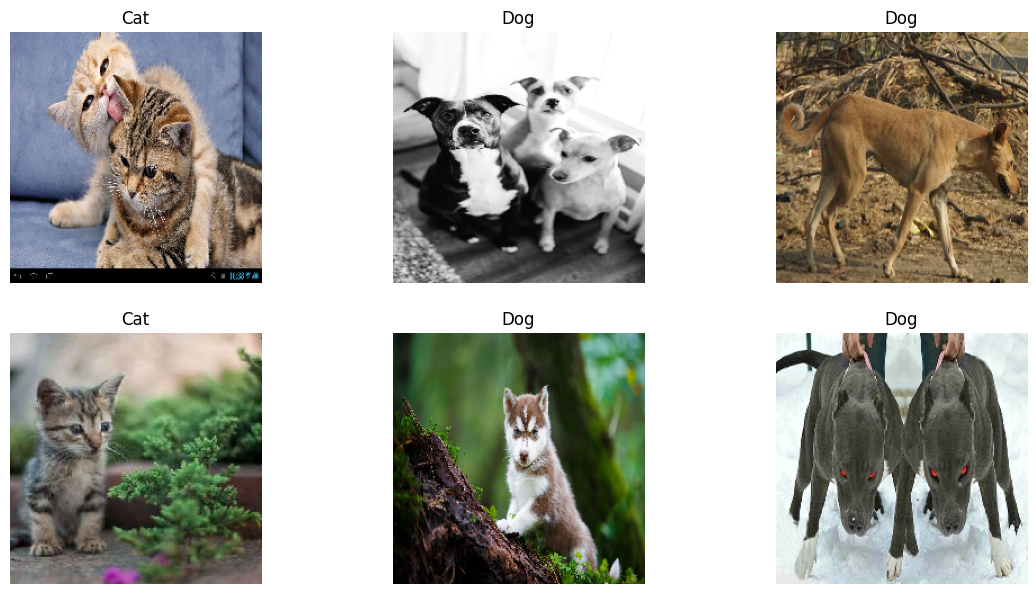

In [38]:
plot_data(train_generator,7)

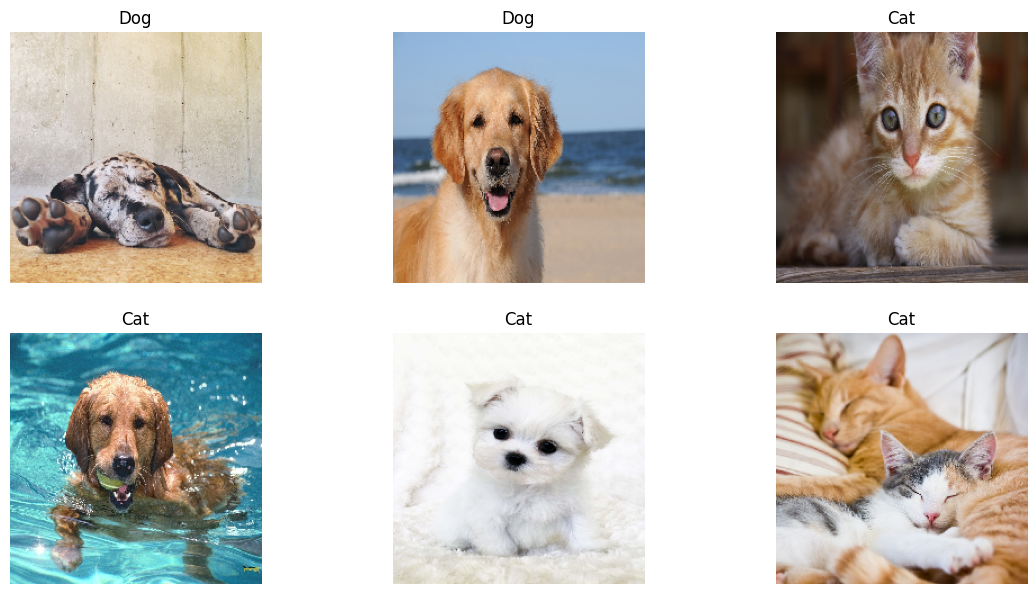

In [39]:
plot_data(validation_generator,7)

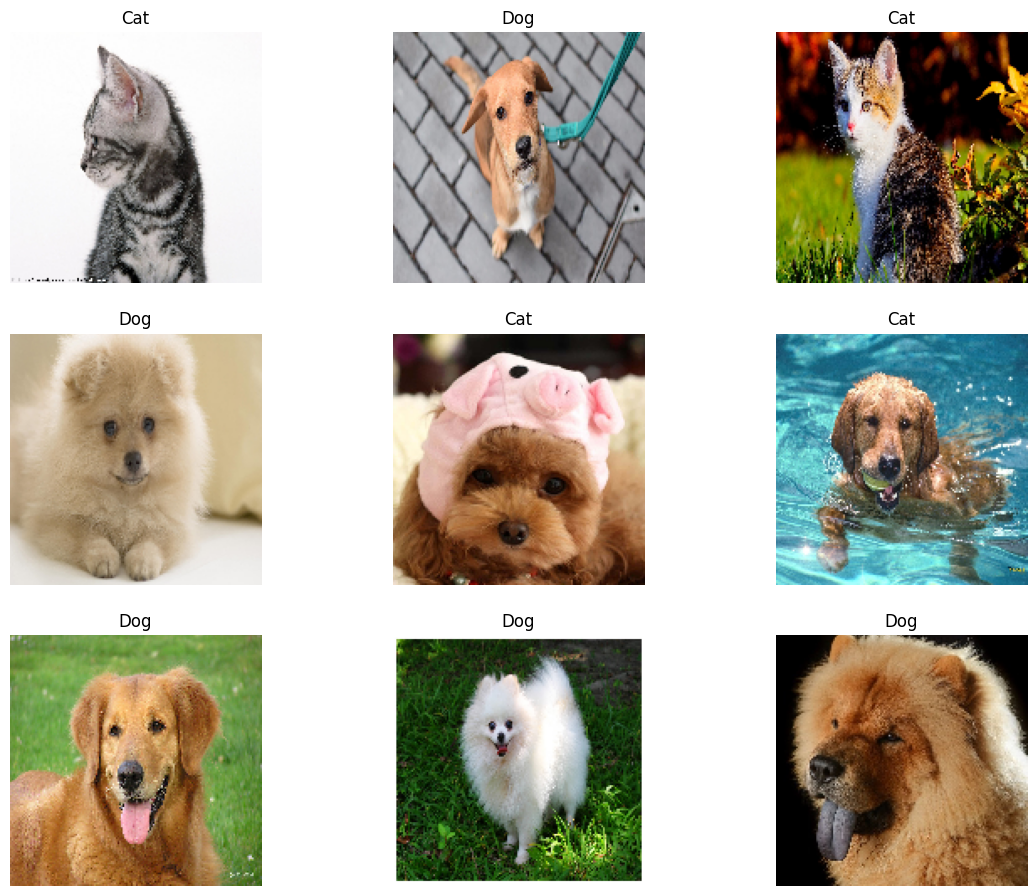

In [40]:
if INCLUDE_TEST:
    plot_data(test_generator, 10)

In [41]:
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [42]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

In [43]:
model = Model(inputs=base_model.input, outputs=predictions)

In [44]:
for layer in base_model.layers:
    layer.trainable = False

In [45]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
epochs = 10
batch_size=8
history = model.fit(
    train_generator,
    steps_per_epoch= None,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size)

Epoch 1/10
53/53 [==============================] - 10s 126ms/step - loss: 0.7528 - accuracy: 0.7947 - val_loss: 0.9873 - val_accuracy: 0.8393
Epoch 2/10
53/53 [==============================] - 6s 120ms/step - loss: 0.2697 - accuracy: 0.8902 - val_loss: 0.6075 - val_accuracy: 0.8393
Epoch 3/10
53/53 [==============================] - 6s 115ms/step - loss: 0.1956 - accuracy: 0.9141 - val_loss: 0.6461 - val_accuracy: 0.7857
Epoch 4/10
53/53 [==============================] - 6s 119ms/step - loss: 0.1728 - accuracy: 0.9165 - val_loss: 0.7036 - val_accuracy: 0.7857
Epoch 5/10
53/53 [==============================] - 6s 113ms/step - loss: 0.1727 - accuracy: 0.9165 - val_loss: 0.8470 - val_accuracy: 0.8214
Epoch 6/10
53/53 [==============================] - 6s 116ms/step - loss: 0.1789 - accuracy: 0.9165 - val_loss: 0.7860 - val_accuracy: 0.8214
Epoch 7/10
53/53 [==============================] - 6s 119ms/step - loss: 0.1668 - accuracy: 0.9141 - val_loss: 0.7486 - val_accuracy: 0.7857
Epoch

In [47]:
if INCLUDE_TEST:
    model.evaluate(test_generator)

1/1 [==============================] - 1s 913ms/step - loss: 2.1869 - accuracy: 0.7719


In [51]:
results = pd.DataFrame(history.history)
results.tail()

,loss,accuracy,val_loss,val_accuracy
5,0.178911,0.916468,0.785963,0.821429
6,0.166804,0.914081,0.748623,0.785714
7,0.163255,0.914081,0.938603,0.803571
8,0.169333,0.921241,1.024650,0.821429
9,0.205230,0.918854,0.864620,0.803571


In [52]:
model.save('catsvdogsv1.h5')

C:\Users\AJAY\anaconda3\envs\tf\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [53]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

8/8 [==============================] - 2s 199ms/step - loss: 0.8495 - accuracy: 0.8070
Validation Loss: 0.8495211005210876
Validation Accuracy: 0.8070175647735596


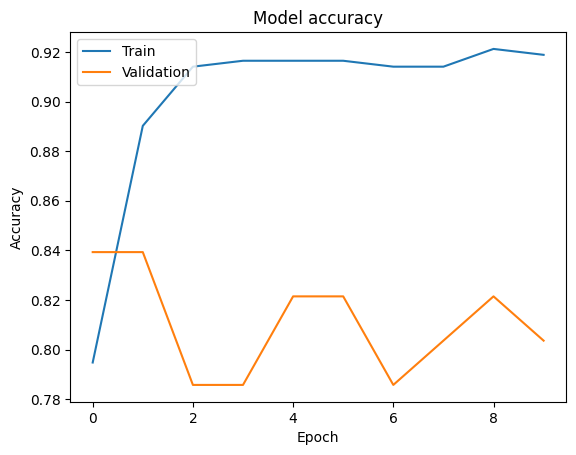

In [54]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

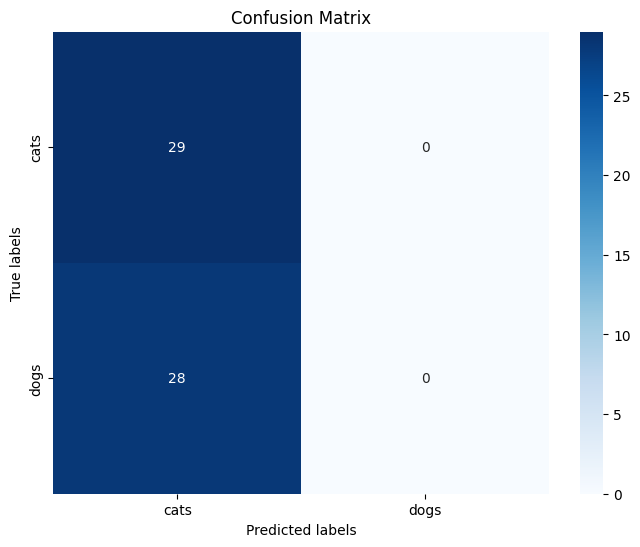

In [55]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict probabilities for the validation set
y_prob = model.predict(validation_generator)

# Convert probabilities to class labels
y_pred = np.argmax(y_prob, axis=1)

# Get true labels
y_true = validation_generator.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=validation_generator.class_indices,
            yticklabels=validation_generator.class_indices)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()